## Basic Setup

In [1]:
%pip install seaborn tikzplotlib
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import tikzplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small', legacy=True)

DF = pd.read_csv('../orcas.tsv', sep='\t', header=None, names=['query', 'docid'])
docid_counts = DF.groupby('docid').count()

def get_embeddings(n_docids, n_queries, min_pop, max_pop):
    """
    Get embeddings of queries grouped by documents.

    Arguments:
    n_docids - number of docs
    n_queries - number of queries per doc
    min_pop - minimum popularity in terms of associated queries per doc
    max_pop - maximum popularity in terms of associated queries per doc
    """
    if min_pop is None:
        min_pop = n_queries
    elif min_pop < n_queries:
        raise Exception('min_pop cannot be smaller than n_queries')

    filter = (docid_counts['query'] >= min_pop)
    if max_pop is not None:
        filter &= (docid_counts['query'] < max_pop)
    
    eligible_docids = docid_counts[filter].index
    df = DF[DF['docid'].isin(eligible_docids)]
    sampled_docids = df['docid'].drop_duplicates().sample(n=n_docids)

    doc_embeddings = torch.empty((0, model.encoder.config.hidden_size), dtype=torch.float32)
    for docid in sampled_docids:
        queries = df[df['docid'] == docid].sample(n=n_queries)['query'].tolist()
        inputs = [tokenizer(query, return_tensors='pt').input_ids for query in queries]
        
        with torch.no_grad():
            query_embeddings = torch.stack([model.encoder(input_ids=input_ids).last_hidden_state.mean(dim=1) for input_ids in inputs]).squeeze(1)
        
        doc_embeddings = torch.cat((doc_embeddings, query_embeddings), dim=0)

    return doc_embeddings

def reduce_embeddings_to_2d(embeddings):
    tsne = TSNE(n_components=2, random_state=42)
    return tsne.fit_transform(embeddings.numpy())

def get_2d_embeddings(n_docids, n_queries, min_pop, max_pop):
    embeddings = get_embeddings(n_docids, n_queries, min_pop, max_pop)
    return reduce_embeddings_to_2d(embeddings)

def get_metrics(embeddings, doc_labels):
    kmeans = KMeans(n_clusters=n_docs, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    
    silhouette = silhouette_score(embeddings, doc_labels)
    silhouette_kmeans = silhouette_score(embeddings, kmeans.labels_)
    
    ari = adjusted_rand_score(doc_labels, kmeans.labels_)
    nmi = normalized_mutual_info_score(doc_labels, kmeans.labels_)

    return dict(
        silhouette=silhouette,
        silhouette_kmeans=silhouette_kmeans,
        ari=ari,
        nmi=nmi
    )

Note: you may need to restart the kernel to use updated packages.


/Users/marcel/anaconda3/envs/mtgjamendo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sample Queries of Highly Popular Documents

In [2]:
eligible_docids = docid_counts[docid_counts['query'] >= 5000].index
df = DF[DF['docid'].isin(eligible_docids)]
sampled_docids = df['docid'].drop_duplicates().sample(n=5)

for docid in sampled_docids:
    # Filter the DataFrame for the current docid and retrieve the 'query' column
    query_values = df[df['docid'] == docid].sample(n=10)['query']
    
    print(f"DocID: {docid}")
    print("Query Values:")
    print(query_values.to_list())
    print("---")

DocID: D627688
Query Values:
['tessped', 'tds speed test', 'bit test', 'speedtest ookla speedtest', 'test performance', 'internett test', 'check my wifi connection speed', 'speed test.xfinity test', 'speedtesting', 'espdteste']
---
DocID: D1310323
Query Values:
['windowsä¸è½½', 'microsoft window', 'microdoft', 'hotmail accedi posta elettronica', 'microsoft sites', 'msn sign in page', 'change microsoft account email', 'https://go.microsoft.com/', 'microsoft accout login', 'www.hotmail.com sign in']
---
DocID: D379730
Query Values:
['yahoo login mail inbox', 'https://mail.yahoo.com/d/folders/6', 'create yahoo account email', 'yshoo.vom', 'www.yahoo.co.uk uk', 'o mail', 'https://www.yahoo.com/?tsrc=samsung_qa', 'yahoo.com/mail/login', 'yhaboo', 'yahoo! correo entrar']
---
DocID: D797874
Query Values:
['whatsup app windows', 'wuasapweb', 'www.whattsapp .com', 'wasatpp web', 'whatsapp up', 'whatapp apk', 'atsapp web', 'http://whatsapp.web.com/', 'whatsapp apk for pc windows 10', 'play store

## Plot: Query Clustering Grouped by Documents

Query embeddings reduced to 2D and rendered in a scatter plot grouped by their associated documents.
Increasing the number of documents shows the increase of density in the semantic space, and therefore the drop in accuracy.
Furthermore, controlling for the document popularity (`min_pop`/`max_pop`) reveals how more popular documents have more diverse queries.

In [16]:
n_docs = 20
n_queries = 40
max_pop = n_queries+10 # used for low pop plot
min_pop = 1000 # used for high pop plot

### Plot for Low Popularity Documents

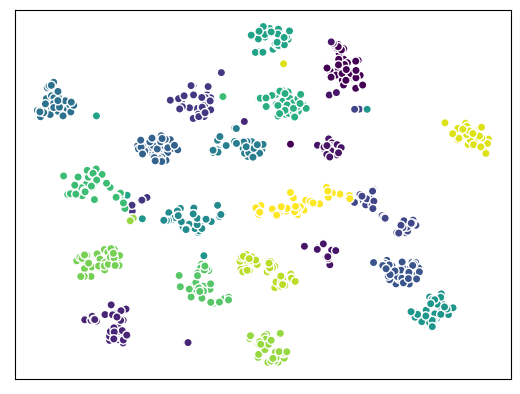

In [56]:
fig, ax = plt.subplots()
ax.set_xticks([]), ax.set_yticks([])

lp_embeddings = get_2d_embeddings(n_docs, n_queries, None, max_pop)
lp_doc_labels = np.repeat(range(n_docs), len(lp_embeddings) // n_docs)
plt.scatter(lp_embeddings[:, 0], lp_embeddings[:, 1], cmap='viridis', c=lp_doc_labels, edgecolors='white')

tikzplotlib.save('../plots/query_clustering_low_pop.tex', axis_width=r'\textwidth', axis_height=r'7cm')

### Plot for High Popularity Documents

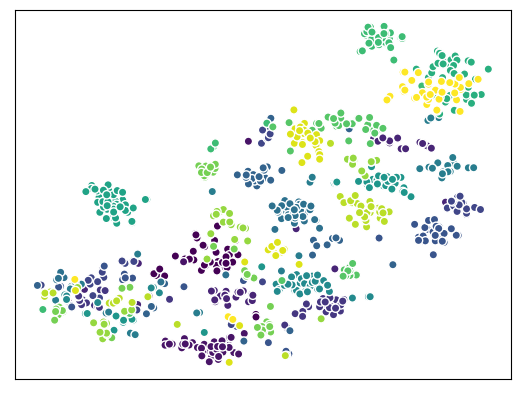

In [57]:
fig, ax = plt.subplots()
ax.set_xticks([]), ax.set_yticks([])

hp_embeddings = get_2d_embeddings(n_docs, n_queries, min_pop, None)
hp_doc_labels = np.repeat(range(n_docs), len(hp_embeddings) // n_docs)
plt.scatter(hp_embeddings[:, 0], hp_embeddings[:, 1], cmap='viridis', c=hp_doc_labels, edgecolor='white')

tikzplotlib.save('../plots/query_clustering_high_pop.tex', axis_width=r'\textwidth', axis_height=r'7cm')

## Table: k-means Clustering and Metrics

Ideally, a k-means clustering of the queries (with `k = n_docs`) yields the same distribution.
Inspecting the k-means clustering, we can derive some interesting metrics, including:

**Silhouette Score:** The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters. [[REF]](https://en.wikipedia.org/wiki/Silhouette_(clustering))

**Adjusted Rand Index (ARI):** ARI values range from -1 to 1. A score of 1 indicates a perfect match between the clustering results and the ground truth, while a score of 0 indicates random clustering, and a negative score suggests less agreement than expected by chance.

**Normalized Mutual Information (NMI):** NMI values range from 0 to 1, where 0 means no mutual information (completely independent clusterings) and 1 indicates perfect correlation between the clustering results and the ground truth.

In [58]:
data = []
metrics = get_metrics(lp_embeddings, lp_doc_labels)
data.append([f'{n_queries}-{n_queries+10}', metrics['silhouette'], metrics['silhouette_kmeans'], metrics['ari'], metrics['nmi']])
metrics = get_metrics(hp_embeddings, hp_doc_labels)
data.append(['1000+', metrics['silhouette'], metrics['silhouette_kmeans'], metrics['ari'], metrics['nmi']])

df = pd.DataFrame(data, columns=['Document Popularity', 'Silhouette', 'Silhouette k-means', 'ARI', 'NMI'])
df

,Document Popularity,Silhouette,Silhouette k-means,ARI,NMI
0,40-50,0.529414,0.647556,0.880991,0.934981
1,1000+,-0.023584,0.474810,0.456847,0.654791


## Plot: ARI over Document Popularity

In [77]:
n_docs_plots = [20, 25, 30, 40]
data = {key: [] for key in n_docs_plots}

for i in range(1,10):
    for _n_docs in n_docs_plots:
        embeddings = get_2d_embeddings(_n_docs, 100, i*100, (i+1)*100)
        doc_labels = np.repeat(range(_n_docs), len(embeddings) // _n_docs)
        metrics = get_metrics(embeddings, doc_labels)
        data[_n_docs].append(metrics['ari'])

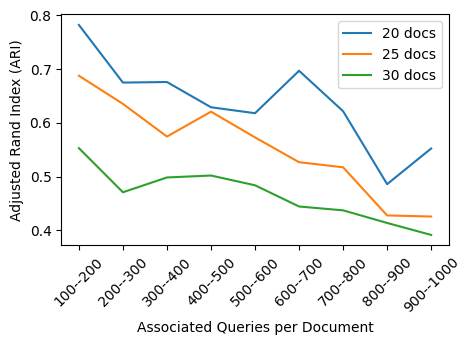

In [83]:
plt.figure(figsize=(5, 3))

for n, _data in data.items():
    if n==40: continue
    plt.plot(_data, label=f'{n} docs')

plt.xlabel('Associated Queries per Document')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.xticks(
    range(9), 
    ["100--200", "200--300", "300--400", "400--500", "500--600", "600--700", "700--800", "800--900", "900--1000"]
)

plt.xticks(rotation=45)
plt.legend()

tikzplotlib.save("../plots/ari_over_doc_pop.tex", axis_width=r'\columnwidth', axis_height=r'6cm')